In [1]:
library(tidyverse)
library(sf)
library(tidycensus)
library(redist)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1



In [3]:
precinct = st_read("C:/Users/madie/OneDrive/data/pre-redist/VA_precinct_2018/VA_precinct_2018.shp")

Reading layer `VA_precinct_2018' from data source `C:\Users\madie\OneDrive\data\pre-redist\VA_precinct_2018\VA_precinct_2018.shp' using driver `ESRI Shapefile'
Simple feature collection with 2463 features and 10 fields
geometry type:  MULTIPOLYGON
dimension:      XYZ
bbox:           xmin: 9963623 ymin: 6151696 xmax: 12442960 ymax: 7217011
z_range:        zmin: 0 zmax: 0
projected CRS:  NAD83 / Virginia North (ftUS)


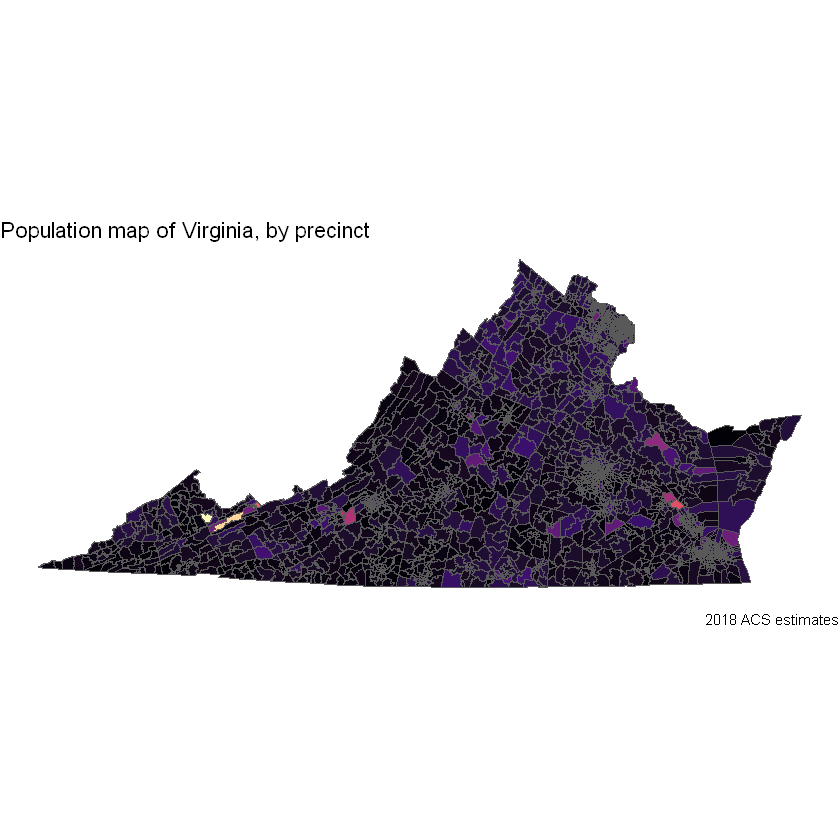

In [4]:
precinct %>% 
  ggplot(aes(fill = pop)) + 
  geom_sf(size = 0, show.legend = FALSE) + 
  scale_fill_viridis_c(option = "magma") + 
  coord_sf(datum = NA) +
  theme_void() + 
  labs(title = "Population map of Virginia, by precinct", caption = "2018 ACS estimates")

In [8]:
head(precinct)

ERROR while rich displaying an object: Error in loadNamespace(name): there is no package called 'geojsonio'

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_geojson.sf(o

,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,pop,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [US_survey_foot]>
1,001,Accomack County,000101,Chincoteague,2,533,1039,0,1,4972,MULTIPOLYGON Z (((12370064 ...
2,001,Accomack County,000201,Atlantic,2,171,482,0,2,1929,MULTIPOLYGON Z (((12319940 ...
3,001,Accomack County,000202,Greenbackville,2,307,595,0,1,1754,MULTIPOLYGON Z (((12348276 ...
4,001,Accomack County,000301,New Church,2,583,490,0,0,2675,MULTIPOLYGON Z (((12304919 ...
5,001,Accomack County,000401,Bloxom,2,118,286,0,0,924,MULTIPOLYGON Z (((12286551 ...
6,001,Accomack County,000402,Parksley,2,242,418,0,1,1422,MULTIPOLYGON Z (((12270326 ...


In [10]:
# the congressional district must be a numeric in order for MCMC to accept it as an initcds
precinct$CON_DIST <- as.numeric(precinct$CON_DIST)

In [19]:
library(sp)
library(spData)
library(spdep)
adjlist <- spdep::poly2nb(precinct, queen = FALSE)

In [15]:
centroid <- st_centroid(precinct$geometry)
distancemat <- st_distance(centroid, centroid)

There are are about 10 precincts that don't have population data (are NA). I'm going to try just setting them to 0 and see if the redistrictin still works properly. 

In [28]:
library(fastStat)
list.NA(precinct$pop)

Loading required package: survC1

Loading required package: survival



NAs,count,percent
<chr>,<chr>,<chr>
NA,10,0.41


In [29]:
precinct$pop[is.na(precinct$pop)] <- 0

In [30]:
list.NA(precinct$pop)

NAs,count,percent
<chr>,<chr>,<chr>
NA,0,0


In [ ]:
start.time <- Sys.time()
mcmc.out.st <- redist.mcmc(adjobj = adjlist,
                           popvec = precinct$pop,
                           initcds = precinct$CON_DIST,
                           nsims = 1000,
                           constraint = c("population", "compact"),
                           constraintweights = c(1, 1),
                           popcons = .1,
                           ssdmat = distancemat,
                           savename = "mcmc_vac_2018_initcds")
end.time <- Sys.time()
print(end.time - start.time)